In [1]:
from collections import defaultdict
import pathlib

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import patsy

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import train_test_split, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

In [255]:
cwd = pathlib.Path.cwd()
data_path = cwd / 'data'
pkl_path = data_path / 'pkl'
observations_pkl = pkl_path /'observations.pkl'

df = pd.read_pickle(observations_pkl).astype(float)
df['Percent_Passed'] = df['Percentage_Standard_Met_and_Above']
df['Math'] = df['Test_Id'] - 1
df['Mean_Score'] = df['Mean_Scale_Score']
df['Percent_Tested'] = df['Students_Tested'] / df['CAASPP_Reported_Enrollment']
df['Participation_95'] = (df['Percent_Tested'] > 0.95).astype(int)
# df = df[['Median_Income', 'Percent_Passed', 'Math', 'Participation_95', 'Percent_Tested', 'Grade', 'Mean_Score']]

In [333]:
raw = 'Type_Id Total_Tested_with_Scores Total_Tested_At_Entity_Level '

y, X = patsy.dmatrices('np.log(Median_Income) ~ Math * np.log(Grade) * np.log(Percent_Passed + 1) + np.log(1.01-Percent_Tested) - Math:np.log(Grade):Mean_Score:np.log(Percent_Passed + 1) + 0'
#                        + '+' + ' + '.join(raw.split())
                       , data=df)


linreg = LinearRegression()
fit = linreg.fit(X, y)
r_squared = linreg.score(X, y)
adjusted_r_squared = 1 - (1 - r_squared) * len(y) / (len(y) - X.shape[1] - 1)
rmse = np.sqrt(mean_squared_error(y, fit.predict(X)))


y_df = pd.DataFrame(y, columns=y.design_info.column_names)
X_df = pd.DataFrame(X, columns=X.design_info.column_names)
interactions = pd.concat([X_df, y_df], axis=1)

print('Intercept:', fit.intercept_)
print('R^2 Score:', r_squared)
print('Adj R^2 Score:', adjusted_r_squared)
print('RMSE Score:', rmse)

Intercept: [10.29923135]
R^2 Score: 0.28978972789184065
Adj R^2 Score: 0.28967742984639056
RMSE Score: 0.31713498883040286


In [329]:
X.design_info.column_names

['Math',
 'np.log(Grade)',
 'Math:np.log(Grade)',
 'np.log(Percent_Passed + 1)',
 'Math:np.log(Percent_Passed + 1)',
 'np.log(Grade):np.log(Percent_Passed + 1)',
 'Math:np.log(Grade):np.log(Percent_Passed + 1)',
 'np.log(1.01 - Percent_Tested)']

In [305]:
import statsmodels.api as sm

lm = sm.OLS(y, sm.add_constant(X))
fit = lm.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                     2903.
Date:                Fri, 25 Jan 2019   Prob (F-statistic):               0.00
Time:                        06:46:52   Log-Likelihood:                -15400.
No. Observations:               56928   AIC:                         3.082e+04
Df Residuals:                   56919   BIC:                         3.090e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.2992      0.024    426.086      0.000      10.252      10.347
x1             0.1322      0.029      4.542      0.000       0.075       0.189
x2             0.1676      0.013     12.671      0.000       0.142       0.194
x3            -0.0012      0.017     -0.070      0.944      -0.034       0.032
x4             2.3923      0.056     42.881      0.000       2.283       2.502
x5            -0.6806      0.076     -9.013      0.000      -0.829      -0.533
x6            -0.5922      0.033    -18.147      0.000      -0.656      -0.528
x7             0.3588      0.044      8.098      0.000       0.272       0.446
x8             0.0409      0.002     23.835      0.000       0.038       0.044
==============================================================================
Omnibus:                      379.886   Durbin-Watson:                   0.276
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              423.839
Skew:                          -0.159   Prob(JB):                     9.22e-93
Kurtosis:                       3.278   Cond. No.                         362.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [237]:
# plot = sns.heatmap(interactions.corr())
# plt.title('Target: Natural Log(Median Income) with Features')
# plot.get_figure().savefig('heatmap.svg', bbox_inches='tight');

In [156]:
# sns.pairplot(interactions);

In [ ]:
# Percent error change happens with RMSE logged

Text(0, 0.5, 'Residuals')

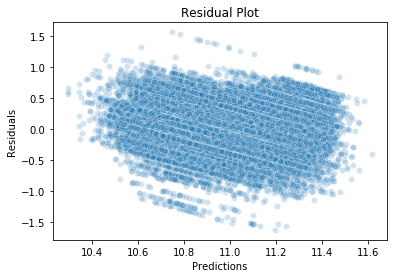

In [308]:
#: For sklearn fit

predictions = fit.predict(X)
residuals = y - fit.predict(X)
plot = sns.scatterplot(x=predictions.ravel(), y=residuals.ravel(), alpha=0.2)
plt.title('Residual Plot')
plt.xlabel('Predictions')
plt.ylabel('Residuals')
# plot.get_figure().savefig('residuals.svg', bbox_inches='tight');

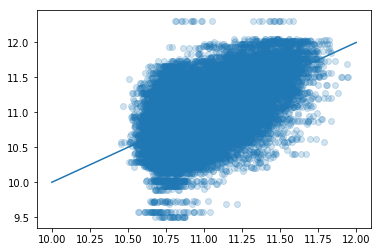

In [266]:
plt.scatter(predictions, y, alpha=0.2)
plt.plot([10, 12] , [10, 12]);

# Cross Fold Validation (80-20) (Train, Test)

In [324]:
X_, X_test, y_, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
X_, y_ = np.array(X_), np.array(y_)

lasso_adj_r2 = defaultdict(list)
ridge_adj_r2 = defaultdict(list)

lasso_mse = defaultdict(list)
ridge_mse = defaultdict(list)

kfold = KFold(n_splits=5, shuffle=True, random_state=10)

for alpha in np.arange(0.001, 1, 0.001):
# for alpha in np.arange(0.003, 1, 0.001):
    for train_idx, valid_idx in kfold.split(X_, y_):
        X_train, y_train = X_[train_idx], y_[train_idx]
        X_valid, y_valid = X_[valid_idx], y_[valid_idx]

        scaler = StandardScaler()
        X_train_scale = scaler.fit_transform(X_train)
        X_valid_scale = scaler.transform(X_valid)

        #: Ridge
        ridge = Ridge(alpha=alpha)
        ridge.fit(X_train_scale, y_train)
        
        r2 = ridge.score(X_valid_scale, y_valid)
        adj_r2 = 1 - (1 - r2) * len(y_valid) / (len(y_valid) - X_valid_scale.shape[1] - 1)
        ridge_adj_r2[alpha].append(adj_r2)

        mse = mean_squared_error(y_valid, ridge.predict(X_valid_scale))
        ridge_mse[alpha].append(mse)
        
        #: LASSO
        lasso = Lasso(alpha=alpha)
        lasso.fit(X_train_scale, y_train)
        
        r2 = lasso.score(X_valid_scale, y_valid)
        adj_r2 = 1 - (1 - r2) * len(y_valid) / (len(y_valid) - X_valid_scale.shape[1] - 1)
        lasso_adj_r2[alpha].append(adj_r2)
        
        mse = mean_squared_error(y_valid, lasso.predict(X_valid_scale))
        lasso_mse[alpha].append(mse)

In [325]:
lasso_mse_mean = {alpha: np.mean(mse) for alpha, mse in lasso_mse.items()}
lasso_mse_optimal = min(lasso_mse_mean.items(), key=lambda x: x[1])

lasso_adj_r2_mean = {alpha: np.mean(adj_r2) for alpha, adj_r2 in lasso_adj_r2.items()}
lasso_adj_r2_optimal = max(lasso_adj_r2_mean.items(), key=lambda x: x[1])

In [326]:
ridge_mse_mean = {alpha: np.mean(mse) for alpha, mse in ridge_mse.items()}
ridge_mse_optimal = min(ridge_mse_mean.items(), key=lambda x: x[1])

ridge_adj_r2_mean = {alpha: np.mean(adj_r2) for alpha, adj_r2 in ridge_adj_r2.items()}
ridge_adj_r2_optimal = max(ridge_adj_r2_mean.items(), key=lambda x: x[1])

In [312]:
linreg_adj_r2 = []
linreg_mse = []

for train_idx, valid_idx in kfold.split(X_, y_):
        X_train, y_train = X_[train_idx], y_[train_idx]
        X_valid, y_valid = X_[valid_idx], y_[valid_idx]

        linreg = LinearRegression()
        linreg.fit(X_train, y_train)
        
        r2 = linreg.score(X_valid, y_valid)
        adj_r2 = 1 - (1 - r2) * len(y_valid) / (len(y_valid) - X_valid.shape[1] - 1)
        linreg_adj_r2.append(adj_r2)
        
        mse = mean_squared_error(y_valid, linreg.predict(X_valid))
        linreg_mse.append(mse)

In [313]:
linreg_adj_r2_mean = np.mean(linreg_adj_r2)
linreg_mse_mean = np.mean(linreg_mse)

### Looks like OLS ties with Ridge so I'll use the more basic

In [327]:
linreg_mse_mean,    lasso_mse_optimal[1],    ridge_mse_optimal[1]

(0.10067587790392145, 0.10093148393675706, 0.10067569153264302)

In [328]:
linreg_adj_r2_mean, lasso_adj_r2_optimal[1], ridge_adj_r2_optimal[1]

(0.2869029336781394, 0.2851035847982211, 0.28690427102712207)

In [316]:
poly_adj_r2 = defaultdict(list)
poly_mse = defaultdict(list)

for degree in range(4):
    for train_idx, valid_idx in kfold.split(X_, y_):
        X_train, y_train = X_[train_idx], y_[train_idx]
        X_valid, y_valid = X_[valid_idx], y_[valid_idx]
        
        poly = PolynomialFeatures(degree=degree)
        X_train_poly = poly.fit_transform(X_train)
        X_valid_poly = poly.transform(X_valid)

        poly = LinearRegression()
        poly.fit(X_train_poly, y_train)
        r2 = poly.score(X_valid_poly, y_valid)
        adj_r2 = 1 - (1 - r2) * len(y_valid) / (len(y_valid) - X_valid_poly.shape[1] - 1)
        poly_adj_r2[degree].append(adj_r2)
        
        mse = mean_squared_error(y_valid, poly.predict(X_valid_poly))
        poly_mse[degree].append(mse)

In [317]:
poly_mse_mean = {degree: np.mean(mse) for degree, mse in poly_mse.items()}
poly_adj_r2_mean = {degree: np.mean(adj_r2) for degree, adj_r2 in poly_adj_r2.items()}

### Polynomial doesn't have better performance than OLS

In [318]:
poly_mse_mean

{0: 0.14139573391162893,
 1: 0.10067587790392145,
 2: 0.09742838086516811,
 3: 0.09673969713674237}

In [319]:
poly_adj_r2_mean

{0: -0.0005043993899957577,
 1: 0.2868245576350533,
 2: 0.307081431468514,
 3: 0.30275217974267155}

In [289]:
alpha_opt = lasso_mse_optimal[0]

scaler = StandardScaler()
X_scale = scaler.fit_transform(X_)
X_test_scale = scaler.transform(X_test)

lasso = Lasso(alpha=alpha_opt)
lasso.fit(X_scale, y_)

r2 = lasso.score(X_test_scale, y_test)
rmse = np.sqrt(mean_squared_error(y_test, lasso.predict(X_test_scale)))

r2, rmse, linreg.intercept_[0], linreg.coef_

/Users/matteding/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


(0.3218756717800542,
 0.3108796265323211,
 14.543371716351418,
 array([[-5.09596175e+00, -2.70745418e+00,  1.36134770e+00,
         -1.44092250e-03,  2.17544978e-03,  1.13090217e-03,
         -5.91714852e-04, -2.32315643e+01,  2.62174411e+00,
          4.91254233e+00,  2.64122547e-01,  1.04212597e-02,
         -1.32512609e-03, -2.51546776e-03,  4.39404441e-02,
         -3.80004344e-02, -3.90970961e-03,  3.97097527e-03]]))

### Now test OLS with the 80% train without CV

In [330]:
linreg = LinearRegression()
linreg.fit(X_, y_)

r2 = linreg.score(X_test, y_test)
rmse = np.sqrt(mean_squared_error(y_test, linreg.predict(X_test)))

r2, rmse, linreg.intercept_[0], linreg.coef_

(0.29545399529321814,
 0.31687813775224544,
 10.310465979437899,
 array([[ 1.29013437e-01,  1.63732675e-01,  2.25186105e-04,
          2.36093118e+00, -6.68478613e-01, -5.75480670e-01,
          3.50497030e-01,  4.18194566e-02]]))

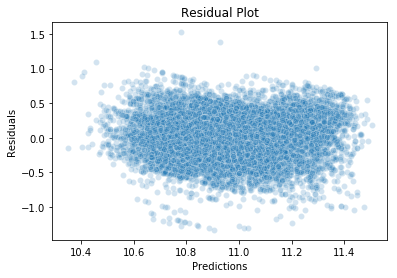

In [321]:

predictions = linreg.predict(X_test)
residuals = y_test - linreg.predict(X_test)
plot = sns.scatterplot(x=predictions.ravel(), y=residuals.ravel(), alpha=0.2)
plt.title('Residual Plot')
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plot.get_figure().savefig('residuals_test.svg', bbox_inches='tight');

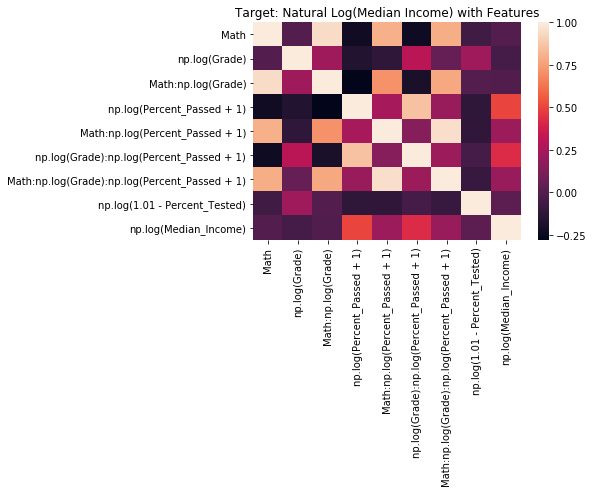

In [323]:
plot = sns.heatmap(interactions.corr())
plt.title('Target: Natural Log(Median Income) with Features')
plot.get_figure().savefig('heatmap.svg', bbox_inches='tight');

In [331]:
lm = sm.OLS(y_test, sm.add_constant(X_test))
fit = lm.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.296
Model:                            OLS   Adj. R-squared:                  0.296
Method:                 Least Squares   F-statistic:                     598.0
Date:                Fri, 25 Jan 2019   Prob (F-statistic):               0.00
Time:                        08:44:48   Log-Likelihood:                -3066.1
No. Observations:               11386   AIC:                             6150.
Df Residuals:                   11377   BIC:                             6216.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.2510      0.055    187.108      0.000      10.144      10.358
x1             0.1460      0.066      2.228      0.026       0.018       0.274
x2             0.1848      0.030      6.160      0.000       0.126       0.244
x3            -0.0073      0.038     -0.193      0.847      -0.081       0.067
x4             2.5263      0.127     19.915      0.000       2.278       2.775
x5            -0.7331      0.171     -4.280      0.000      -1.069      -0.397
x6            -0.6639      0.074     -8.946      0.000      -0.809      -0.518
x7             0.3942      0.101      3.921      0.000       0.197       0.591
x8             0.0370      0.004      9.592      0.000       0.029       0.045
==============================================================================
Omnibus:                       84.035   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               92.251
Skew:                          -0.173   Prob(JB):                     9.29e-21
Kurtosis:                       3.274   Cond. No.                         367.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

How I collected data
Why I chose topic
Understanding Results
Next Steps
Appendix

- What were the benefits of the Feature Engineering vs just using a nieve model
- What other types of models did I try --> why did I choose OLS over Ridge despite it being slightly worse?
- 
dept of educ: https://pbs.twimg.com/profile_images/938093844146483200/FBIh5VvF.jpg  
money stack: http://www.onlineinvestingai.com/blog/wp-content/uploads/2009/12/passive-income.gif  
caaspp: http://p12cdn4static.sharpschool.com/UserFiles/Servers/Server_580721/Image/CAASPP/CAASPP%20TRANSPARENT.gif  


In [ ]:
X_.col

In [ ]:
y_.

Intercept: [12.79115535]
R^2 Score: 0.33350275912690086
Adj R^2 Score: 0.33324508964917954
RMSE Score: 0.30722026730806884
